In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [11]:
import io
import bson #pip install pymongo, not pip install bson. if you've installed bson, uninistall it first by pip uninstall bson
from skimage.data import imread
import multiprocessing as mp
from tqdm import tqdm_notebook

In [5]:
# Simple data processing
data = bson.decode_file_iter(open('./data/train_example.bson', 'rb'))
prod_to_category = dict()

for c, d in enumerate(data):
    product_id = d['_id']
    category_id = d['category_id']
    prod_to_category[product_id] = category_id
    for e, pic in enumerate(d['imgs']):
        picture = imread(io.BytesIO(pic['picture']))
    
prod_to_category = pd.DataFrame.from_dict(prod_to_category, orient='index')
prod_to_category.index.name = '_id'
prod_to_category.rename(columns={0:'category_id'}, inplace=True)

In [6]:
prod_to_category.head()

,category_id
_id,
0,1000010653
1,1000010653
2,1000004079
3,1000004141
4,1000015539


/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


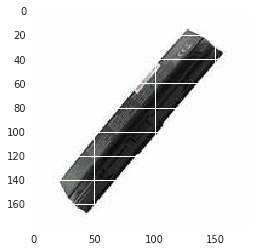

In [7]:
plt.imshow(picture)

In [19]:
NCORE = 8
prod_to_category = mp.Manager().dict()

def process(q, iolock):
    while True:
        d = q.get()
        if d is None:
            break
        product_id = d['_id']
        category_id = d['category_id']
        prod_to_category[product_id] = category_id
        for e, pic in enumerate(d['imgs']):
            picture = imread(io.BytesIO(pic['picture']))
    
q = mp.Queue(maxsize=NCORE)
iolock = mp.Lock()
pool = mp.Pool(NCORE, initializer=process, initargs=(q, iolock))

# process the file
data = bson.decode_file_iter(open('./data/train_example.bson', 'rb'))
for c, d in enumerate(data):
    q.put(d) #blocks until q below its max size
    
# tell workers we're done

for _ in range(NCORE):
    q.put(None)
pool.close()
pool.join()

#convert back to normal dictionary
prod_to_category  = dict(prod_to_category)

prod_to_category = pd.DataFrame.from_dict(prod_to_category, orient='index')
prod_to_category.index.name = '_id'
prod_to_category.rename(columns={0:'category_id'}, inplace=True)